In [1]:
from arcgis.features import GeoAccessor
import pandas as pd
import numpy as np

import sys
sys.path.append('../src/geoai_retail')
import utils

%load_ext autoreload
%autoreload 2

In [2]:
geo_fc = '../data/raw/raw.gdb/blocks'
geo_id_fld = 'GEOID'

enrich_csv = '../data/raw/blocks_enriched.csv'
enrich_id_fld = 'GEOID'

closest_csv =  '../data/interim/closest_table.csv'
closest_factor_fld_root = 'trip_count'

trips_csv = '../data/raw/trips_od.csv'

store_fc = '../data/raw/raw.gdb/coffee'
store_id_fld = 'LOCNUM'

In [3]:
store_df = GeoAccessor.from_featureclass(store_fc)
store_df.head()

,OBJECTID,LOCNUM,CONAME,STREET,CITY,STATE,STATE_NAME,ZIP,ZIP4,NAICS,...,FRNCOD,ISCODE,SQFTCODE,LOC_NAME,STATUS,SCORE,SOURCE,REMOVE,open_status,SHAPE
0,1,413963145,SNOW PEAK COFFEE CO,HILLWOOD RD SE,JEFFERSON,OR,Oregon,97352,9212,72251505,...,,,1,PointAddress,M,100.0,INFOGROUP,0,None,"{""x"": -122.99270000035045, ""y"": 44.77610000019..."
1,2,422168012,BAD GIRLS COFFEE,PARRISH GAP RD SE,TURNER,OR,Oregon,97392,9565,72251505,...,,,1,PointAddress,M,100.0,INFOGROUP,0,None,"{""x"": -122.96479999992164, ""y"": 44.79579999981..."
2,3,244210043,DUTCH BROTHERS COFFEE,SE JEFFERSON ST,DALLAS,OR,Oregon,97338,2023,72251505,...,Y,,2,PointAddress,M,100.0,INFOGROUP,0,None,"{""x"": -123.31560000023427, ""y"": 44.92460000005..."
3,4,396819021,STARBUCKS,E ELLENDALE AVE,DALLAS,OR,Oregon,97338,1523,72251505,...,4,,2,PointAddress,M,100.0,INFOGROUP,0,None,"{""x"": -123.30960000042165, ""y"": 44.92999999968..."
4,5,396819062,STARBUCKS,W ELLENDALE AVE,DALLAS,OR,Oregon,97338,1408,72251505,...,4,,2,PointAddress,M,100.0,INFOGROUP,0,None,"{""x"": -123.31230000023731, ""y"": 44.93040000014..."


In [4]:
store_df = store_df[[store_id_fld, 'CONAME', 'SHAPE']].copy()
store_df.head()

,LOCNUM,CONAME,SHAPE
0,413963145,SNOW PEAK COFFEE CO,"{""x"": -122.99270000035045, ""y"": 44.77610000019..."
1,422168012,BAD GIRLS COFFEE,"{""x"": -122.96479999992164, ""y"": 44.79579999981..."
2,244210043,DUTCH BROTHERS COFFEE,"{""x"": -123.31560000023427, ""y"": 44.92460000005..."
3,396819021,STARBUCKS,"{""x"": -123.30960000042165, ""y"": 44.92999999968..."
4,396819062,STARBUCKS,"{""x"": -123.31230000023731, ""y"": 44.93040000014..."


In [5]:
brand_df = store_df.groupby('CONAME').count()[store_id_fld].sort_values(ascending=False).to_frame()
brand_df.reset_index(inplace=True)
brand_df.columns = ['name', 'location_count']
brand_df.head(25)

,name,location_count
0,STARBUCKS,298
1,DUTCH BROTHERS COFFEE,49
2,UNCLE GARY'S COFFEE EMPORIUM,15
3,ALLEGRO COFFEE,7
4,HUMAN BEAN,7
5,BLACK ROCK COFFEE BAR,6
6,STUMPTOWN COFFEE ROASTERS,4
7,CITY COFFEE,4
8,BLACK ROCK COFFEE,3
9,BLUE MOON COFFEE,3


In [6]:
brand_df['store_name_category'] = brand_df.apply(lambda row: row['name'] if row['location_count'] > 1 else 'INDEPENDENT', axis=1)
brand_df.head(25)

,name,location_count,store_name_category
0,STARBUCKS,298,STARBUCKS
1,DUTCH BROTHERS COFFEE,49,DUTCH BROTHERS COFFEE
2,UNCLE GARY'S COFFEE EMPORIUM,15,UNCLE GARY'S COFFEE EMPORIUM
3,ALLEGRO COFFEE,7,ALLEGRO COFFEE
4,HUMAN BEAN,7,HUMAN BEAN
5,BLACK ROCK COFFEE BAR,6,BLACK ROCK COFFEE BAR
6,STUMPTOWN COFFEE ROASTERS,4,STUMPTOWN COFFEE ROASTERS
7,CITY COFFEE,4,CITY COFFEE
8,BLACK ROCK COFFEE,3,BLACK ROCK COFFEE
9,BLUE MOON COFFEE,3,BLUE MOON COFFEE


In [7]:
store_df = store_df.join(brand_df[['name', 'store_name_category']].set_index('name'), on='CONAME')
store_df.head()

,LOCNUM,CONAME,SHAPE,store_name_category
0,413963145,SNOW PEAK COFFEE CO,"{""x"": -122.99270000035045, ""y"": 44.77610000019...",INDEPENDENT
1,422168012,BAD GIRLS COFFEE,"{""x"": -122.96479999992164, ""y"": 44.79579999981...",INDEPENDENT
2,244210043,DUTCH BROTHERS COFFEE,"{""x"": -123.31560000023427, ""y"": 44.92460000005...",DUTCH BROTHERS COFFEE
3,396819021,STARBUCKS,"{""x"": -123.30960000042165, ""y"": 44.92999999968...",STARBUCKS
4,396819062,STARBUCKS,"{""x"": -123.31230000023731, ""y"": 44.93040000014...",STARBUCKS


In [8]:
closest_df = pd.read_csv(closest_csv, index_col=0)
closest_df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,proximity_kilometers_04,proximity_minutes_04
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,895875482,1.880792,4.141975
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,895875482,1.690762,3.602913
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,895875482,2.015593,4.567463
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,895875482,1.812533,3.926522
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,895875482,1.909548,3.428834


In [9]:
trips_df = pd.read_csv(trips_csv, usecols=['origin_id', 'destination_id', 'trip_count'])
trips_df.head()

,origin_id,destination_id,trip_count
0,410050201001002,421983243,1
1,410050201001002,520835364,3
2,410050201001002,585558430,1
3,410050201001002,637497553,1
4,410050201001002,721916379,1


In [10]:
closest_trips_df = utils.add_metric_by_origin_dest(closest_df, trips_df, 'trip_count', 0)
closest_trips_df[closest_trips_df['trip_count_01'] > 0].head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,proximity_kilometers_04,proximity_minutes_04,trip_count_01,trip_count_02,trip_count_03,trip_count_04
210,410050202001009,895875409,0.515215,2.279156,257782771,0.554985,2.075903,424721410,0.699375,2.580870,404395221,0.791984,2.324222,7.0,16.0,3.0,0.0
211,410050202001010,895875409,0.664737,3.064725,257782771,0.704507,2.861472,404395221,0.819690,2.602385,424721410,0.848897,3.366439,30.0,71.0,0.0,14.0
212,410050202001011,257782771,0.068048,0.411882,895875409,0.269932,0.492594,424721410,0.454092,0.794309,404395221,0.609298,1.181729,6.0,11.0,5.0,0.0
296,410050202004034,895875409,1.354955,3.731247,257782771,1.394725,3.527994,424721410,1.539115,4.032961,479761744,1.918384,3.943817,40.0,22.0,2.0,4.0
297,410050202004035,895875409,1.445931,3.998697,257782771,1.485702,3.795444,424721410,1.630091,4.300411,479761744,2.009361,4.211267,4.0,20.0,0.0,18.0


In [11]:
closest_trips_store_df = utils.add_metric_by_dest(closest_trips_df, store_df, 'LOCNUM', 'store_name_category')
closest_trips_store_df[closest_trips_store_df['trip_count_01'] > 0].head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,...,proximity_kilometers_04,proximity_minutes_04,trip_count_01,trip_count_02,trip_count_03,trip_count_04,store_name_category_01,store_name_category_02,store_name_category_03,store_name_category_04
210,410050202001009,895875409,0.515215,2.279156,257782771,0.554985,2.075903,424721410,0.699375,2.580870,...,0.791984,2.324222,7.0,16.0,3.0,0.0,STARBUCKS,STARBUCKS,INDEPENDENT,STARBUCKS
211,410050202001010,895875409,0.664737,3.064725,257782771,0.704507,2.861472,404395221,0.819690,2.602385,...,0.848897,3.366439,30.0,71.0,0.0,14.0,STARBUCKS,STARBUCKS,STARBUCKS,INDEPENDENT
212,410050202001011,257782771,0.068048,0.411882,895875409,0.269932,0.492594,424721410,0.454092,0.794309,...,0.609298,1.181729,6.0,11.0,5.0,0.0,STARBUCKS,STARBUCKS,INDEPENDENT,STARBUCKS
296,410050202004034,895875409,1.354955,3.731247,257782771,1.394725,3.527994,424721410,1.539115,4.032961,...,1.918384,3.943817,40.0,22.0,2.0,4.0,STARBUCKS,STARBUCKS,INDEPENDENT,INDEPENDENT
297,410050202004035,895875409,1.445931,3.998697,257782771,1.485702,3.795444,424721410,1.630091,4.300411,...,2.009361,4.211267,4.0,20.0,0.0,18.0,STARBUCKS,STARBUCKS,INDEPENDENT,INDEPENDENT


In [12]:
closest_trips_store_df = utils.add_metric_by_dest(closest_trips_df, store_df, 'LOCNUM', 'store_name_category', True)
closest_trips_store_df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,...,store_name_category_04_DUTCH_BROTHERS_COFFEE,store_name_category_04_GAIA_JAVA,store_name_category_04_HUMAN_BEAN,store_name_category_04_INDEPENDENT,store_name_category_04_INSOMNIA_COFFEE_CO,store_name_category_04_JIM_PATTYS_COFFEE,store_name_category_04_STARBUCKS,store_name_category_04_STUMPTOWN_COFFEE_ROASTERS,store_name_category_04_SYMPOSIUM_COFFEE,store_name_category_04_UNCLE_GARYS_COFFEE_EMPORIUM
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,...,0,0,0,0,0,0,1,0,0,0
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,...,0,0,0,0,0,0,1,0,0,0
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,...,0,0,0,0,0,0,1,0,0,0
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,...,0,0,0,0,0,0,1,0,0,0
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,...,0,0,0,0,0,0,1,0,0,0


In [13]:
enrich_df = pd.read_csv(enrich_csv)
enrich_df.drop(columns=['OBJECTID', 'Shape_Length', 'Shape_Area'], inplace=True)
enrich_df['GEOID'] = enrich_df['GEOID'].astype('int64')
enrich_df.set_index('GEOID', inplace=True)
enrich_df.head()

,groupquarters_gqpop_cy,generations_genalphacy,generations_genz_cy,generations_millenn_cy,generations_genx_cy,generations_babyboomcy,generations_oldrgenscy,generations_genbase_cy,gender_pop0_cy,gender_pop5_cy,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
GEOID,,,,,,,,,,,,,,,,,,,,,
410710303014029,0.0,2.0,21.0,18.0,21.0,20.0,6.0,88.0,5.0,6.0,...,5.0,5.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,59.0
410710303014030,0.0,3.0,26.0,22.0,26.0,25.0,7.0,108.0,6.0,7.0,...,6.0,6.0,0.0,3.0,3.0,1.0,2.0,2.0,0.0,72.0
410710303014031,0.0,1.0,6.0,5.0,6.0,6.0,2.0,27.0,2.0,2.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,18.0
410710303014032,0.0,4.0,35.0,29.0,35.0,34.0,9.0,145.0,8.0,10.0,...,8.0,8.0,0.0,4.0,3.0,1.0,2.0,2.0,0.0,97.0
410710303014033,0.0,1.0,10.0,9.0,10.0,10.0,3.0,43.0,3.0,3.0,...,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,29.0


In [14]:
full_df = closest_trips_store_df.join(enrich_df, on='origin_id')
full_df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,...,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,27.0
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [86]:
full_df.info()
full_df.to_parquet('../data/interim/full_joined_data.parquet')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64930 entries, 0 to 64929
Columns: 1309 entries, origin_id to schoolenrollment_acsnotnsch
dtypes: float64(1220), int64(89)
memory usage: 648.9 MB


In [85]:
full_df_lessna = full_df.dropna()
full_df_lessna.to_parquet('../data/interim/full_data_less_na.parquet')
full_df_lessna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56026 entries, 0 to 64929
Columns: 1309 entries, origin_id to schoolenrollment_acsnotnsch
dtypes: float64(1220), int64(89)
memory usage: 560.0 MB


In [87]:
full_df = full_df_lessna

In [88]:
label_col = 'trip_count_01'
factor_cols = [col for col in full_df if not 'destination_id_' in col and not 'trip_count_' in col and col != 'origin_id' and col != label_col]

In [89]:
factor_uint8_lst = [factor for factor in factor_cols if full_df[factor].dtype == 'uint8']
for factor in factor_uint8_lst:
    full_df[factor] = full_df[factor].astype('int64')

In [90]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pickle
plt.style.use('dark_background')
%matplotlib inline

In [91]:
X = full_df[factor_cols].copy()
y = full_df[label_col].copy()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = MinMaxScaler()
imputer = SimpleImputer()
X_train = scaler.fit_transform(X_train)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgis\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [93]:
forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
forest_regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
%%time
mdl = forest_regressor.fit(X_train, y_train)
mdl

Wall time: 18min 14s


In [95]:
mdl = fit_reg
mdl_path = r'../models/pdx_coffee_forest_fill_null_0.pkl'

with open(mdl_path, 'wb') as mdl_file:
    pickle.dump(mdl, mdl_file)
    mdl_file.close()

In [96]:
mdl = pickle.load(open(mdl_path, 'rb'))

In [97]:
y_pred = mdl.predict(X_test)

In [98]:
r2 = r2_score(y_test, y_pred)
r2

-485.70296340810455

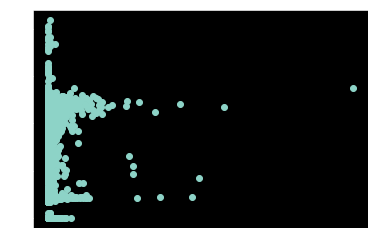

In [99]:
plt.scatter(y_test, y_pred)

In [100]:
y_train_pred = fit_reg.predict(X_train)

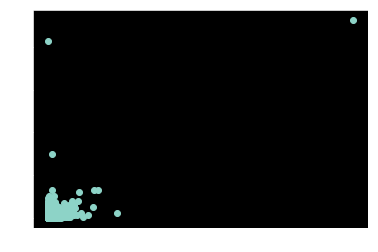

In [101]:
plt.scatter(y_train, y_train_pred)

In [102]:
r2_score(y_train, y_train_pred)

0.4064346613761888

In [79]:
rdg_mdl = Ridge(random_state=42)

In [80]:
rdg_mdl.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [81]:
y_rdg_predict = rdg_mdl.predict(X_test)

In [82]:
r2_score(y_test, y_rdg_predict)

-1770849758401133.0

In [83]:
y_rdg_predict_train = rdg_mdl.predict(X_train)

In [84]:
r2_score(y_train, y_rdg_predict_train)

0.18803242637270978